# Deep Learning Pipeline for Tweet Classification

This notebook presents a robust, production-ready deep learning pipeline for tweet classification. The workflow demonstrates practices in data preprocessing, feature engineering, model design, optimization, and evaluation, with a focus on reproducibility and scalability.

> **Note:** This notebook was originally developed in `project1.ipynb`.

## Core Pipeline Functions

This section defines all core functions for data preprocessing, neural network modeling, and utility operations. The pipeline is modular and can be easily extended or integrated into production systems.

### Preparation 

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import random
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

### Data Preprocessing

This section details the data preprocessing pipeline, which is critical for robust NLP model performance. The pipeline includes:
- Removal of non-alphabetic characters to reduce noise
- Conversion to lowercase for normalization
- Lemmatization to reduce words to their base form
- Stop word removal to focus on informative tokens

Additional functions are provided for entity replacement (e.g., links, hashtags, mentions, numbers, uppercase words) and can be enabled as needed for experiments or integration with pre-trained embeddings. The modular design allows for easy adaptation to new datasets or evolving requirements in production environments.

In [ ]:
#transforms the data of given dataframe
def data_preprocessing(df):
#   remove_links(df)
#   remove_hashtags(df)
#   remove_mentions(df)
#   replace_links(df)
#   replace_hashtags(df)
#   replace_mentions(df)
#   replace_numbers(df)
#   replace_upper_words(df)
  remove_non_alpha(df)
  to_lowercase(df)
  lemmatize(df)
  remove_stop_words(df)

def remove_links(df):
  df.update(df.apply(lambda x: re.sub(r'(https?:\/\/[A-Za-z0-9\/.]*)|(bit.ly\/[A-Za-z0-9\/.]*)', '', x, flags=re.MULTILINE)))

def remove_non_alpha(df):
  df.update(df.apply(lambda x: re.sub(r'[^ a-zA-Z]', ' ', x, flags=re.MULTILINE)))

def to_lowercase(df):
  df.update(df.apply(lambda x: x.lower()))

def lemmatize(df):
  lemmatizer = WordNetLemmatizer() 
  df.update(df.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in tokenizer(x)])))

def remove_stop_words(df):
  stop = set(stopwords.words('english'))
  df.update(df.apply(lambda x: ' '.join([word for word in tokenizer(x) if word not in (stop)])))

def remove_hashtags(df):
  df.update(df.apply(lambda x: re.sub(r'(#[A-Za-z0-9]*)', '',x, flags=re.MULTILINE)))

def remove_mentions(df):
  df.update(df.apply(lambda x: re.sub(r'(@[A-Za-z0-9]*)', '',x, flags=re.MULTILINE)))
  
def replace_mentions(df):
  df.update(df.apply(lambda x: re.sub(r'(@[A-Za-z0-9]*)', '<user>',x, flags=re.MULTILINE)))
  
def replace_hashtags(df):
  df.update(df.apply(lambda x: re.sub(r'(#[A-Za-z0-9]*)', '<hashtag>',x, flags=re.MULTILINE)))
  
def replace_numbers(df):
  df.update(df.apply(lambda x: re.sub(r"[-+]?\d*\.\d+|\d+", '<number>',x, flags=re.MULTILINE)))

def replace_upper_words(df):
  df.update(df.apply(lambda x: re.sub(r'( [A-Z]* )', ' <allcaps> ',x, flags=re.MULTILINE)))

def replace_links(df):
  df.update(df.apply(lambda x: re.sub(r'(https?:\/\/[A-Za-z0-9\/.]*)|(bit.ly\/[A-Za-z0-9\/.]*)', '<url>', x, flags=re.MULTILINE)))


### Utilities

This section provides essential utility functions for the pipeline, including:
- Tokenization with support for special tokens and entity placeholders
- Loading and applying pre-trained GloVe embeddings
- Vectorization of text data for both TF-IDF and embedding-based models
- ROC curve plotting and learning curve visualization for model evaluation
- Calculation of precision, recall, f1, and accuracy metrics for both training and validation sets
- Batch-wise results display and metric tracking for robust model assessment

These utilities enable reproducible experiments, facilitate model comparison, and support production-level evaluation and reporting.

In [ ]:
#a tokenizer that recognizes the special_tokens list as tokens
def tokenizer(input_str):
    final_tokens = []
    special_tokens = ['<user>','<allcaps>','<hashtag>','<number>','<url>']
    for token in special_tokens:
        for i in range(input_str.count(token)):
            final_tokens.append(token)
        input_str = input_str.replace(token,'')
    final_tokens += word_tokenize(input_str)
    return final_tokens


#load glove model
#got ideas from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
def load_pre_trained_model(filename):
  pretrained_model=dict()
  with open(filename,'r') as fd:
    for line in fd:
      tokens = line.split()
      pretrained_model[tokens[0]]=np.array(tokens[1:],dtype=np.float32)

  return pretrained_model


#vectorize df using word embeddings
def vectorize(df,vocabulary):
  vectorized_docs = df.apply(
      lambda x: [vocabulary[word] for word in tokenizer(x) if word in vocabulary.keys()]
  )
  document_embeddings = vectorized_docs.apply(
      lambda doc: np.mean(doc,dtype=np.float32,axis=0) if doc!=[] else [0 for i in range(len(random.choice(list(glove_pretrained_model.values()))))]
  )
  return document_embeddings


def ROCplot(testy,predy):
    classesc=[0,1,2]
    test_y = label_binarize(testy,classes=classesc)
    pred_y = label_binarize(predy,classes=classesc)
    n_classes=3

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y[:, i], pred_y[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Plot all ROC curves
    plt.figure()
    colors = ['red','blue', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classesc[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


def learning_curve_plot(epochs, train_scores, test_scores, yaxis='Loss'):
    plt.grid()
    plt.title("Learning curve Result")
    plt.xlabel("Epochs")
    plt.ylabel(yaxis)
    plt.fill_between(
        epochs,
        train_scores,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        epochs,
        test_scores,
        alpha=0.1,
        color="g",
    )
    plt.plot(
        epochs, train_scores, "o-", color="r", label="Training score"
    )
    plt.plot(
        epochs, test_scores, "o-", color="g", label="Validation score"
    )
    plt.legend(loc="best")
    plt.show()


#returns a dataframe holding precision,recall,f1,accurasy scores
#test on training and validation sets
def get_scores(trainTrue,trainPred,validationTrue,validationPred):

    scores={}
    scores['set']=[]
    scores['precision']=[]
    scores['f1']=[]
    scores['recall']=[]
    scores['accuracy']=[]

    scores['set'].append('Training')
    scores['precision'].append(metrics.precision_score(trainTrue,trainPred,average='weighted',zero_division=0))
    scores['f1'].append(metrics.f1_score(trainTrue,trainPred,average='weighted',zero_division=0))
    scores['recall'].append(metrics.recall_score(trainTrue,trainPred,average='weighted',zero_division=0))
    scores['accuracy'].append(metrics.accuracy_score(trainTrue,trainPred))

    scores['set'].append('Validation')
    scores['precision'].append(metrics.precision_score(validationTrue,validationPred,average='weighted',zero_division=0))
    scores['f1'].append(metrics.f1_score(validationTrue,validationPred,average='weighted',zero_division=0))
    scores['recall'].append(metrics.recall_score(validationTrue,validationPred,average='weighted',zero_division=0))
    scores['accuracy'].append(metrics.accuracy_score(validationTrue,validationPred))

    return  pd.DataFrame(data=scores).set_index('set')


def display_results(Y_train,Y_validation,Pred_train,Pred_validation,Loss_train,
                    Loss_validation,Score_train,Score_validation,epochs):
    display(get_scores(Y_train,Pred_train,Y_validation,Pred_validation))
    learning_curve_plot(epochs, Loss_train, Loss_validation, yaxis='Loss')
    learning_curve_plot(epochs, Score_train, Score_validation, yaxis='f1')
    ROCplot(Y_validation,Pred_validation)

### Neural Network

This section defines the core neural network architecture and training utilities used in the pipeline. The neural network is implemented using PyTorch and is designed for modularity and extensibility. The architecture supports:
- Customizable layer configurations (e.g., number of layers, units, activation functions, dropout)
- Integration with various optimizers and learning rate schedulers
- Efficient training and evaluation using DataLoader and custom Dataset classes
- Support for both TF-IDF and GloVe embedding input representations

The implementation follows best practices for production-ready deep learning systems, including:
- Clear separation of model definition, training, and evaluation logic
- Use of label smoothing and regularization to mitigate overfitting
- Batch-wise training and validation with real-time metric tracking
- Compatibility with a wide range of loss functions and optimizers

This design enables rapid experimentation and easy adaptation to new datasets or requirements in real-world NLP applications.

In [ ]:
#got ideas from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
class NeuralNetwork(nn.Module):
    def __init__(self, layers):
        super(NeuralNetwork, self).__init__()
        self.layers = layers

    def forward(self, x):
        logits = self.layers(x)
        return logits


class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx],dtype=torch.float32),self.y[idx]
        
        
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_sum, score_sum = 0,0

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        score_sum += metrics.f1_score(y,pred.argmax(1),average='weighted',zero_division=0)
        loss_sum += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_sum/num_batches, score_sum/num_batches


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_sum, score_sum = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss_sum += loss_fn(pred, y).item()
            score_sum += metrics.f1_score(y,pred.argmax(1),average='weighted',zero_division=0)

    return loss_sum/num_batches, score_sum/num_batches


#init dataloader and train the model
def run_model(X_train, Y_train, X_validation, Y_validation, batch_size, epochs,
              lr_scheduler, loss_fn, optimizer, model):
    Set_train = CustomDataset(X_train,Y_train)
    Set_validation = CustomDataset(X_validation,Y_validation)

    Dataloader_train = DataLoader(Set_train, batch_size=batch_size, num_workers=2)
    Dataloader_validation = DataLoader(Set_validation, batch_size=batch_size, num_workers=2)

    Loss_train=[]
    Loss_validation=[]
    Score_train=[]
    Score_validation=[]

    for current_epoch in range(epochs):
        epoch_loss_train, epoch_score_train = train_loop(Dataloader_train, model, loss_fn, optimizer)
        epoch_loss_validation, epoch_score_validation = test_loop(Dataloader_validation, model, loss_fn)
        lr_scheduler.step()

        Loss_train.append(epoch_loss_train)
        Loss_validation.append(epoch_loss_validation)
        Score_train.append(epoch_score_train)
        Score_validation.append(epoch_score_validation)

    Pred_train = model(torch.tensor(X_train,dtype=torch.float32)).argmax(dim=1)
    Pred_validation = model(torch.tensor(X_validation,dtype=torch.float32)).argmax(dim=1)

    display_results(Y_train,Y_validation,Pred_train,Pred_validation,Loss_train,
                    Loss_validation,Score_train,Score_validation,range(epochs))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data Collection

Import and preprocess the datasets for model training and evaluation.

In [ ]:
training_set_path = "drive/MyDrive/AI2_project1/vaccine_train_set.csv"
validation_set_path = "drive/MyDrive/AI2_project1/vaccine_validation_set.csv"


#set manual seeds

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)


#importing datasets

train = pd.read_csv(training_set_path,usecols=['tweet','label'])
validation = pd.read_csv(validation_set_path,usecols=['tweet','label'])


#data preprocessing

data_preprocessing(train['tweet'])
data_preprocessing(validation['tweet'])

## Model 1: TF-IDF + Feedforward Neural Network

**Configuration:**
- Layers: [input, 1024], [1024, 512], [512, 3]
- Activation: ELU + Dropout
- Loss: Cross Entropy
- Optimizer: SGD with Momentum
- LR Scheduler: Exponential decay
- Vectorizer: TF-IDF
- Batch size: 32
- Epochs: 12

,precision,f1,recall,accuracy
set,,,,
Training,0.670265,0.668102,0.682962,0.682962
Validation,0.667872,0.665566,0.677914,0.677914


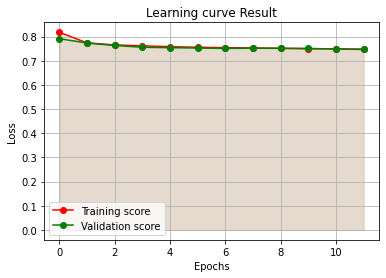

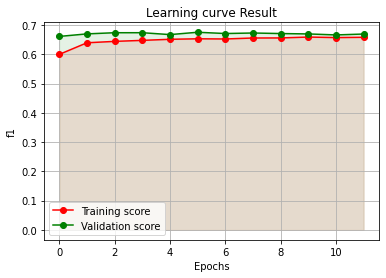

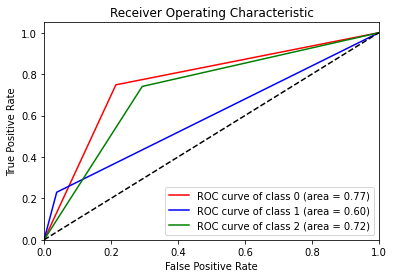

In [ ]:
#model hyperparameters

learning_rate = 0.1
batch_size = 32
epochs = 12


#vectorize data via TF-IDF Vectorizer

vectorizer = TfidfVectorizer(min_df=0.01,max_df=0.4,ngram_range=(1,5),max_features=1000)
X_train = np.array(vectorizer.fit_transform(train['tweet']).toarray())
X_validation = np.array(vectorizer.transform(validation['tweet']).toarray())
Y_train, Y_validation = train['label'], validation['label']


#initialize neural network with prerequisite layers below

layers = nn.Sequential(
    nn.Linear(len(X_train[0]), 1024),
    nn.Dropout(0.25),
    nn.ELU(),
    nn.Linear(1024, 512),
    nn.Dropout(0.25),
    nn.ELU(),
    nn.Linear(512, 3),
)

model = NeuralNetwork(layers)


#Loss function: Cross entropy 
#using label smoothing to avoid minor overfitting

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.01)


#Optimizer: SGD using momentum

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7)


#LR scheduler: exponential decrease

lr_scheduler = ExponentialLR(optimizer, gamma=0.9)


#train the model and print results

run_model(X_train, Y_train, X_validation, Y_validation, batch_size, epochs,
              lr_scheduler, loss_fn, optimizer, model)

## Model 2: GloVe Embeddings + Feedforward Neural Network

**Configuration:**
- Layers: [input, 1024], [1024, 512], [512, 3]
- Activation: LeakyReLU + Dropout
- Loss: Cross Entropy
- Optimizer: SGD with Momentum
- Regularizer: L2 (weight_decay=1e-3)
- LR Scheduler: Exponential decay
- Vectorizer: GloVe 300d
- Batch size: 32
- Epochs: 14

--2021-12-23 13:19:44--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-23 13:19:45--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.25MB/s    in 2m 41s  

2021-12-23 13:22:27 (5.09 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


,precision,f1,recall,accuracy
set,,,,
Training,0.709269,0.694120,0.698986,0.698986
Validation,0.679370,0.665466,0.674408,0.674408


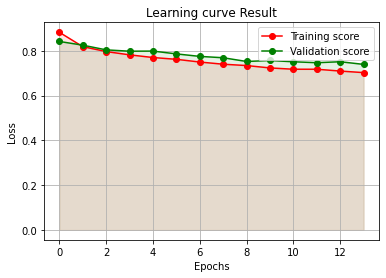

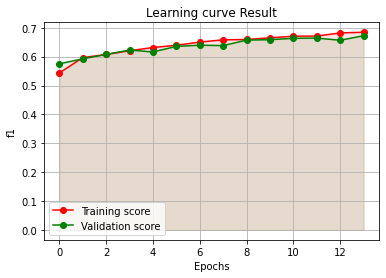

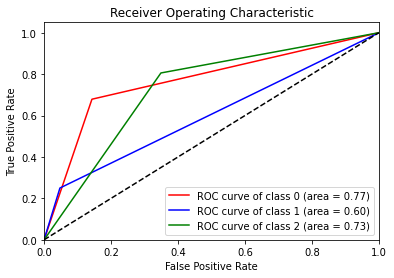

In [ ]:
#model hyperparameters

learning_rate = 0.1
batch_size = 32
epochs = 14


#download the glove pre trained embeddings

!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


#load the pre-trained model

glove_pretrained_model = load_pre_trained_model("glove.6B.300d.txt")


#vectorize data

X_train = vectorize(train['tweet'],glove_pretrained_model)
X_validation = vectorize(validation['tweet'],glove_pretrained_model)
Y_train,Y_validation = train['label'],validation['label']


#initialize neural network with prerequisite layers below

layers = nn.Sequential(
    nn.Linear(len(X_train[0]), 1024),
    nn.Dropout(0.75),
    nn.LeakyReLU(),
    nn.Linear(1024, 512),
    nn.Dropout(0.75),
    nn.LeakyReLU(),
    nn.Linear(512, 3),
)

model = NeuralNetwork(layers)


#Loss function: Cross entropy 
#using label smoothing to avoid minor overfitting

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.01)


#Optimizer: SGD using momentum
#Regularizer: L2 regularization via weight_decay

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7, weight_decay=1e-3)


#LR scheduler: exponential decrease

lr_scheduler = ExponentialLR(optimizer, gamma=0.9)


#train the model and print results

run_model(X_train, Y_train, X_validation, Y_validation, batch_size, epochs,
              lr_scheduler, loss_fn, optimizer, model)

## Supplementary Material for Experiments

### Loss Functions

The following loss functions were evaluated:

In [ ]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.01)
loss_fn = nn.NLLLoss()

### Optimizers

The following optimizers were evaluated:

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7, weight_decay=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=0.7)
optimizer = torch.optim.Adagrad(model.parameters())
optimizer = torch.optim.Adagrad(model.parameters(),weight_decay=1e-3)
optimizer = torch.optim.Adagrad(model.parameters(),lr=learning_rate)
optimizer = torch.optim.RMSprop(model.parameters())
optimizer = torch.optim.RMSprop(model.parameters(), alpha=0.9)
optimizer = torch.optim.RMSprop(model.parameters(),lr=learning_rate)
optimizer = torch.optim.RMSprop(model.parameters(),lr=learning_rate, alpha=0.6)
optimizer = torch.optim.RMSprop(model.parameters(), alpha=0.6)
optimizer = torch.optim.RMSprop(model.parameters(), alpha=0.6, weight_decay=1e-3)
optimizer = torch.optim.RMSprop(model.parameters(),lr=learning_rate, centered=True)
optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-3)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-3, betas=(0.5,0.5))
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, amsgrad=True)
optimizer = torch.optim.Adamax(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adamax(model.parameters())
optimizer = torch.optim.Adamax(model.parameters(), weight_decay=1e-4)
optimizer = torch.optim.Adamax(model.parameters(), weight_decay=1e-3, betas=(0.8,0.8))
optimizer = torch.optim.NAdam(model.parameters(), momentum_decay=4e-1)
optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-3)

### GloVe Pre-Trained Embeddings

The following word set embeddings were evaluated:

In [ ]:
pretrained_model_path = "drive/MyDrive/glove/glove.twitter.27B.50d.txt"
pretrained_model_path = "drive/MyDrive/glove/glove.twitter.27B.25d.txt"
pretrained_model_path = "drive/MyDrive/glove/glove.twitter.27B.100d.txt"
pretrained_model_path = "drive/MyDrive/glove/glove.twitter.27B.200d.txt"
pretrained_model_path = "drive/MyDrive/glove/glove.6B.200d.txt"
pretrained_model_path = "drive/MyDrive/glove/glove.6B.100d.txt"
pretrained_model_path = "drive/MyDrive/glove/glove.6B.300d.txt"
pretrained_model_path = "drive/MyDrive/glove/glove.6B.50d.txt"

### Utility Functions

For dataset adaptation to word embeddings, the functions `count_tokens_found` and `get_tokens_found` were developed. The `get_weights` function returns the class weights based on dataset frequency.

In [ ]:
def get_weights(y,classes=3):
    return torch.tensor([list(y).count(i)/len(y) for i in range(classes)])

def count_tokens_found(df,model):
  exists=0
  not_exists=0
  p = df.apply(lambda x: len([ word for word in tokenizer(x) if word in model.keys()]))
  for i in p:
    exists=exists+i
  p = df.apply(lambda x: len([ word for word in tokenizer(x) if word not in model.keys()]))
  for i in p:
    not_exists=not_exists+i
  print(exists,not_exists)


def get_tokens_found(df,model):
  win = df.apply(lambda x: [word for word in tokenizer(x) if word in model.keys()])
  wnotin = df.apply(lambda x: [word for word in tokenizer(x) if word not in model.keys()])
  return win, wnotin